# Copulas

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig

This notebook is part of the paper "Copula-Based Multi-User Performance Bounds - Part I: Theory" ([doi:XXX](https://doi.org/XXX)).  
If you use any of this work, please cite the above paper.

## Basic Copulas

The first important copulas that will be shown in the following are the Fréchet-Hoeffding bounds $W$ and $M$ and the product copula $\Pi$. The latter corresponds to independent random variables.

The lower and upper bound are given by
$$W(a, b) = \max(a+b-1, 0)$$
and
$$M(a, b) = \min(a, b)$$
respectively.

In [1]:
%matplotlib notebook
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from ipywidgets import interact
from copulas import CopulaFrechetLower, CopulaFrechetUpper, CopulaProduct, CopulaGaussian

In [11]:
def plot_copulas_3d():
    u = np.linspace(0, 1, 30)
    U, V = np.meshgrid(u, u)
    X = [U, V]
    copulas = {"P": CopulaProduct().cdf(X),
               "M": CopulaFrechetUpper().cdf(X),
               "W": CopulaFrechetLower().cdf(X)}
    fig, ax = plt.subplots(1,1, subplot_kw={"projection": "3d"})
    plots = {}
    for _name, _cop in copulas.items():
        plots[_name] = ax.plot_surface(U, V, _cop, alpha=.75)
    ax.set_xlabel("a")
    ax.set_ylabel("b")
    ax.set_zlabel("C(a, b)")
    def plot_visible(**kwargs):
        for _name, _vis in kwargs.items():
            plots[_name].set_visible(_vis)
    interact(plot_visible, M=True, W=True, P=True)

<IPython.core.display.Javascript object>


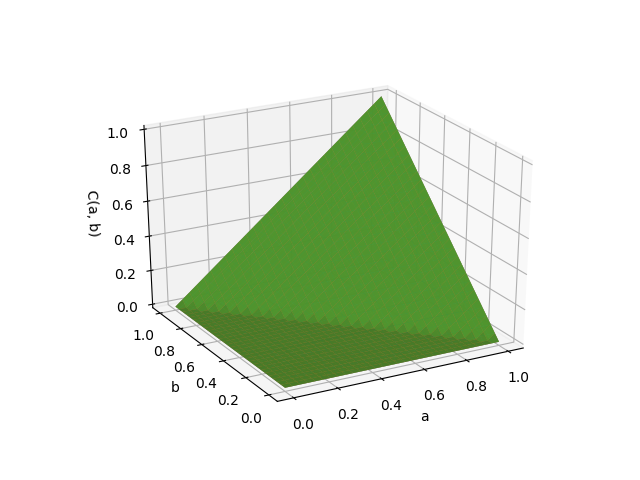

interactive(children=(Checkbox(value=True, description='M'), Checkbox(value=True, description='W'), Checkbox(v…

In [12]:
plot_copulas_3d()

In [23]:
def plot_copulas_contour():
    a = np.linspace(0, 1, 20)
    A, B = np.meshgrid(a, a)
    copulas = {"M": CopulaFrechetUpper().cdf([A, B]),
               "W": CopulaFrechetLower().cdf([A, B]),
               "P": CopulaProduct().cdf([A, B]),
               #"G": CopulaGaussian(cov=-.3).cdf([A, B])
              }
    fig, ax = plt.subplots(1, len(copulas))
    for idx, (_name, _cop) in enumerate(copulas.items()):
        _ax = ax[idx]
        _contour = _ax.contour(A, B, _cop)
        _ax.clabel(_contour, inline=1, fontsize=9)
        _ax.set_title(_name)
        #_ax.set_xlabel("a")
        #_ax.set_ylabel("b")
    fig.tight_layout()

<IPython.core.display.Javascript object>


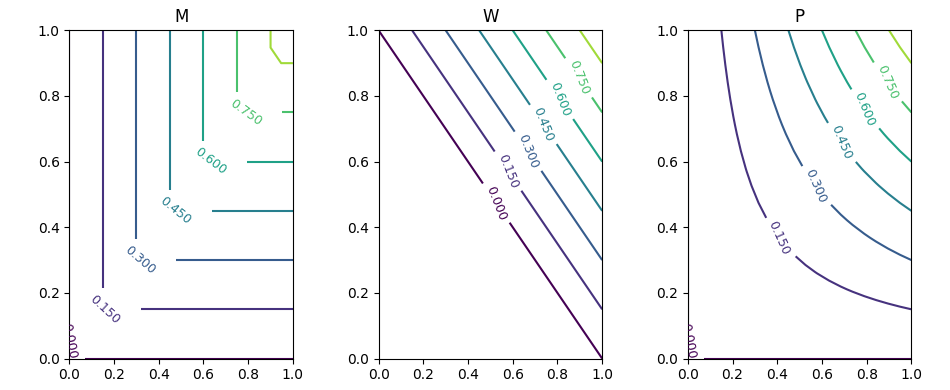

In [24]:
plot_copulas_contour()

## Examples

In the following, we will give some (numerical) examples of different copulas.

First, we will show two random variables following the three fundamental copulas $M$, $W$, and $\Pi$ that we illustrated above. The first rv ${X}$ is exponentially distributed. The second one ${Y}$ is standard-normal. However, you can simply change the distributions by changing the variables `dist_x` and `dist_y` in the following function. 

In [34]:
def plot_example_distributions(N=1000):
    dist_x = stats.expon
    dist_y = stats.norm
    u = {"P": CopulaProduct().rvs(N),
         "M": CopulaFrechetUpper().rvs(N),
         "W": CopulaFrechetLower().rvs(N),
        }
    jointgrid = sns.JointGrid(0, 0)#(*u["M"].T)
    def plot_visible(**kwargs):
        jointgrid.ax_joint.clear()
        jointgrid.ax_marg_x.clear()
        jointgrid.ax_marg_y.clear()
        jointgrid.ax_joint.set_xlabel("x")
        jointgrid.ax_joint.set_ylabel("y")
        for _name, _u in u.items():
            if not kwargs[_name]:
                continue
            x = dist_x.ppf(_u[:, 0])
            y = dist_y.ppf(_u[:, 1])
            sns.kdeplot(x, ax=jointgrid.ax_marg_x, legend=False)
            sns.kdeplot(y, ax=jointgrid.ax_marg_y, vertical=True, legend=False)
            jointgrid.x = x
            jointgrid.y = y
            jointgrid.plot_joint(sns.scatterplot)
    interact(plot_visible, M=True, W=True, P=True)

<IPython.core.display.Javascript object>


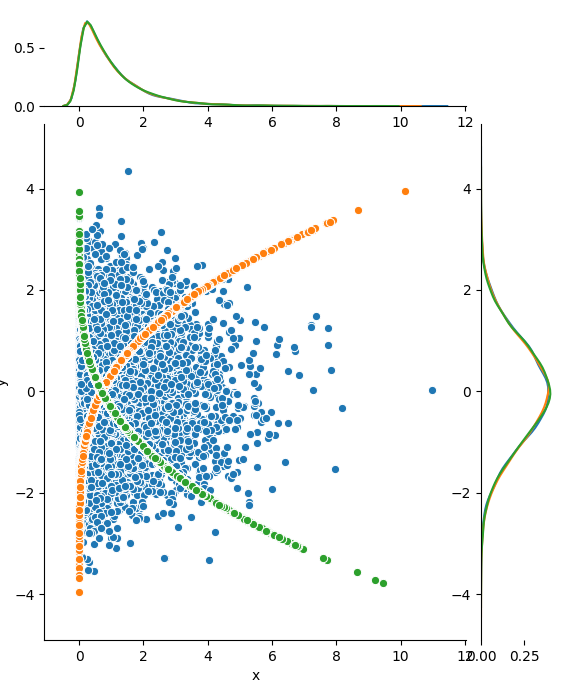

interactive(children=(Checkbox(value=True, description='M'), Checkbox(value=True, description='W'), Checkbox(v…

In [35]:
plot_example_distributions(10000)

Next, we show the distribution when ${X}$ and ${Y}$ follow a Gaussian copula. The Gaussian copula is parametrized by the correlation parameter $\rho$ which controls how dependent the variables are. It can be seen that the variables are comonotonic for $\rho=1$ and countermonotonic for $\rho=-1$.

In [41]:
%%capture
from matplotlib import animation
from IPython.display import HTML

def plot_gaussian_copula(N=1000):
    dist_x = stats.expon
    dist_y = stats.norm
    grid = sns.JointGrid(0, 0)
    def plot(cov=0):
        u = CopulaGaussian().rvs(N, cov)
        x = dist_x.ppf(u[:, 0])
        y = dist_y.ppf(u[:, 1])
        grid.ax_joint.clear()
        grid.ax_marg_x.clear()
        grid.ax_marg_y.clear()
        grid.ax_joint.set_xlabel("x")
        grid.ax_joint.set_ylabel("y")
        grid.ax_joint.set_xlim([-1, 9])
        grid.ax_joint.set_ylim([-4, 4])
        grid.x = x
        grid.y = y
        grid.plot(sns.scatterplot, sns.distplot)
    interact(plot, cov=(-1, 1, .05))

def animation_gaussian_copula(N=1000):
    dist_x = stats.expon
    dist_y = stats.norm
    fig, ax = plt.subplots()
    ax.set_xlim([-1, 9])
    ax.set_ylim([-4, 4])
    scat = ax.scatter([], [])
    cov_list = np.linspace(-1, 1, 50)
    def update_plot(i):
        u = CopulaGaussian().rvs(N, cov_list[i])
        x = dist_x.ppf(u[:, 0])
        y = dist_y.ppf(u[:, 1])
        scat.set_offsets(np.stack((x, y)).T)
        ax.set_title("Cov={:.3f}".format(cov_list[i]))
        return scat,
    ani = animation.FuncAnimation(fig, update_plot, interval=150, frames=len(cov_list), blit=True)
    return ani
ani = animation_gaussian_copula().to_jshtml()

<IPython.core.display.Javascript object>


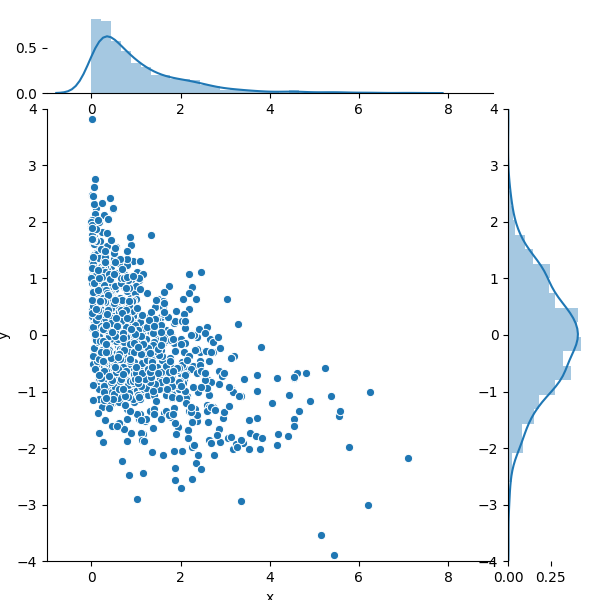

interactive(children=(FloatSlider(value=0.0, description='cov', max=1.0, min=-1.0, step=0.05), Output()), _dom…

In [42]:
plot_gaussian_copula()

In [29]:
#HTML(animation_gaussian_copula().to_jshtml())
HTML(ani)